In [1]:
import pandas as pd
import geopandas as gpd
from shapely import Point
import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet(r'maine_pred_normalization.parquet')

In [3]:
df.head(1)

,Longitude,Latitude,len_forward,len_backward,angle,offset,area,arc,ratio1,ratio2,case,decision_tree_predicted
0,-70.607901,42.979219,62.69,18.19,0.0,0.0,0.0,24.424197,0.056396,0.0,no,0


In [4]:
df.dtypes

Longitude                  float64
Latitude                   float64
len_forward                float64
len_backward               float64
angle                      float64
offset                     float64
area                       float64
arc                        float64
ratio1                     float64
ratio2                     float64
case                        object
decision_tree_predicted      int64
dtype: object

In [5]:
gdf = gpd.GeoDataFrame(data=df, geometry= [ Point(row.Longitude,row.Latitude) for row in df.itertuples()] )

In [6]:
gdf.head(1)

,Longitude,Latitude,len_forward,len_backward,angle,offset,area,arc,ratio1,ratio2,case,decision_tree_predicted,geometry
0,-70.607901,42.979219,62.69,18.19,0.0,0.0,0.0,24.424197,0.056396,0.0,no,0,POINT (-70.60790 42.97922)


In [7]:
gdf = gdf.set_crs(4326)

In [8]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
gdf_ml_no = gdf[gdf['decision_tree_predicted']==0]
gdf_ml_yes = gdf[gdf['decision_tree_predicted']==1]

In [10]:
convex_hull = gdf_ml_yes.unary_union.convex_hull
convex_hull_gdf = gpd.GeoDataFrame(geometry=[convex_hull])

In [11]:
len(gdf_ml_yes)

503

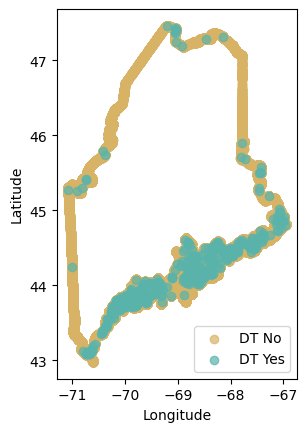

In [12]:
ax = gdf_ml_no.plot(color='#d8b365', alpha=0.7)
gdf_ml_yes.plot(ax=ax, color='#5ab4ac', alpha=0.7)
#convex_hull_gdf.plot(ax=ax, color='red', alpha=0.4)

# Add legend and labels if needed
plt.legend(['DT No', 'DT Yes'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

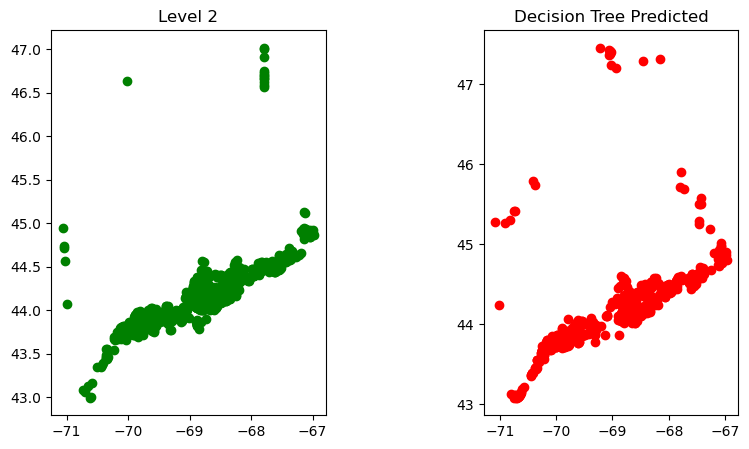

In [41]:
# Create subplots with three columns
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot each GeoDataFrame on a separate subplot

head_maine_gdf_l2.plot(ax=axs[0], color='green')
axs[0].set_title('Level 2')

gdf_ml_yes.plot(ax=axs[1], color='red')
axs[1].set_title('Decision Tree Predicted')

# Adjust spacing between subplots
# plt.tight_layout()

# Show the plot
plt.show()

In [89]:
gdf_ml_yes.to_file(r'D:\Sid_Map_Projects\Georef_Mahi\Maine_Yes.shp')

C:\Users\Sidrcs\AppData\Local\Temp\ipykernel_13400\3611805426.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_ml_yes.to_file(r'D:\Sid_Map_Projects\Georef_Mahi\Maine_Yes.shp')


### Applying Topfers Algorithm (Jiang et al 2013)

In [14]:
def df_to_gdf(file):
    try:
        if file.endswith('.csv'):
            df = pd.read_csv(file)
            gdf = gpd.GeoDataFrame(data=df, geometry=[Point(row.Longitude,row.Latitude) for row in df.itertuples()])
            gdf = gdf.set_crs(4326)
            return gdf
        if file.endswith('.parq') or file.endswith('.parquet'):
            df = pd.read_parquet(file)
            gdf = gpd.GeoDataFrame(data=df, geometry=[Point(row.Longitude,row.Latitude) for row in df.itertuples()])
            gdf = gdf.set_crs(4326)
            return gdf
        else:
            print('But yeah !! CSV or Parq is accepted')
    except Exception as error:
        print(f'An error occured:{error}')

In [15]:
# Step1: Take the pre-generalized shapefile
maine_pregen_gdf = df_to_gdf('Vertices_Labels/Maine.parq')

In [16]:
maine_pregen_gdf.head(1)

,Longitude,Latitude,case,len_forward,len_backward,angle,offset,area,arc,ratio1,ratio2,geometry
0,-70.607901,42.979219,no,62.69,18.19,0.0,0.0,0.0,24.424197,0.056396,0.0,POINT (-70.60790 42.97922)


In [17]:
len(maine_pregen_gdf)

294372

In [18]:
mean_forward_length = maine_pregen_gdf['len_forward'].mean()
mean_forward_length

83.92751425921712

In [19]:
head_maine_gdf = maine_pregen_gdf[maine_pregen_gdf['len_forward'] >= mean_forward_length]
tail_maine_gdf = maine_pregen_gdf[maine_pregen_gdf['len_forward'] < mean_forward_length]

In [20]:
len(head_maine_gdf), len(tail_maine_gdf)

(13831, 280540)

In [21]:
print(f'Head points:{round((len(head_maine_gdf)/len(maine_pregen_gdf))*100,2)}%')

Head points:4.7%


In [22]:
print(f'Tail points:{round((len(tail_maine_gdf)/len(maine_pregen_gdf))*100,2)}%')

Tail points:95.3%


Text(0.5, 1.0, 'Maine Level 1')

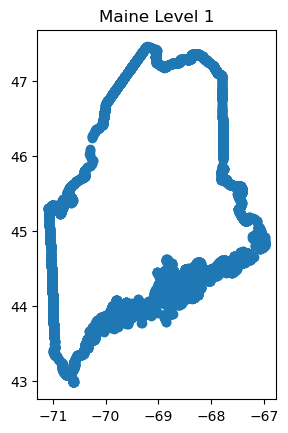

In [23]:
head_maine_gdf.plot()
plt.title('Maine Level 1')

In [24]:
mean_forward_length_l2 = head_maine_gdf['len_forward'].mean()
mean_forward_length_l2

1328.0948427445594

In [25]:
head_maine_gdf_l2 = head_maine_gdf[head_maine_gdf['len_forward'] >= mean_forward_length_l2]
tail_maine_gdf_l2 = head_maine_gdf[head_maine_gdf['len_forward'] < mean_forward_length_l2]

In [26]:
len(head_maine_gdf_l2), len(tail_maine_gdf_l2)

(1226, 12605)

In [27]:
print(f'Head points:{round((len(head_maine_gdf_l2)/len(head_maine_gdf))*100,2)}%')

Head points:8.86%


In [28]:
print(f'Tail points:{round((len(tail_maine_gdf_l2)/len(head_maine_gdf))*100,2)}%')

Tail points:91.14%


Text(0.5, 1.0, 'Maine Level2')

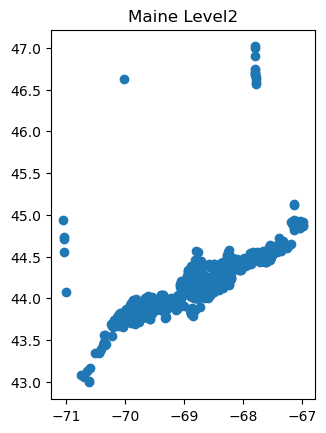

In [29]:
head_maine_gdf_l2.plot()
plt.title('Maine Level2')

In [30]:
mean_forward_length_l3 = head_maine_gdf_l2['len_forward'].mean()
mean_forward_length_l3

13435.464200652532

In [31]:
head_maine_gdf_l3 = head_maine_gdf_l2[head_maine_gdf_l2['len_forward'] >= mean_forward_length_l3]
tail_maine_gdf_l3 = head_maine_gdf_l2[head_maine_gdf_l2['len_forward'] < mean_forward_length_l3]

In [32]:
len(head_maine_gdf_l3), len(tail_maine_gdf_l3)

(476, 750)

In [33]:
print(f'Head points:{round((len(head_maine_gdf_l3)/len(head_maine_gdf_l2))*100,2)}%')

Head points:38.83%


In [34]:
print(f'Tail points:{round((len(tail_maine_gdf_l3)/len(head_maine_gdf_l2))*100,2)}%')

Tail points:61.17%


Text(0.5, 1.0, 'Maine Level 3')

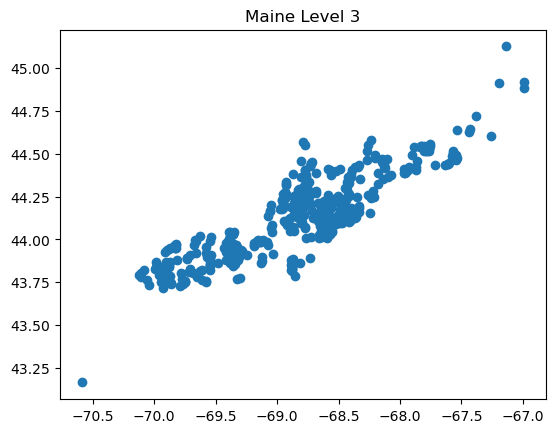

In [35]:
head_maine_gdf_l3.plot()
plt.title('Maine Level 3')

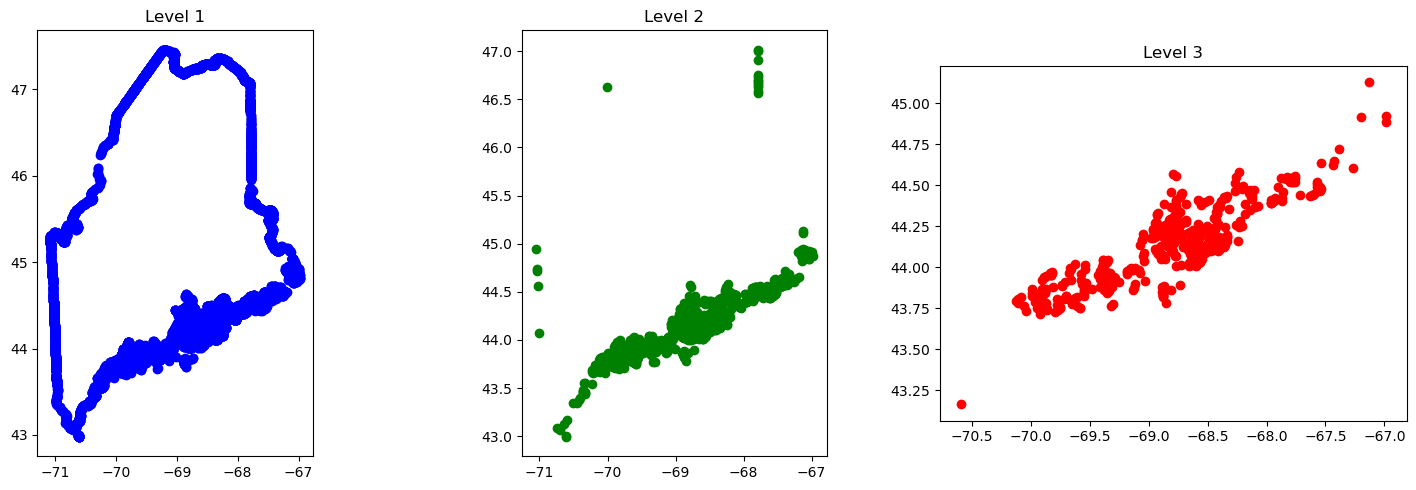

In [36]:
# Create subplots with three columns
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot each GeoDataFrame on a separate subplot
head_maine_gdf.plot(ax=axs[0], color='blue')
axs[0].set_title('Level 1')

head_maine_gdf_l2.plot(ax=axs[1], color='green')
axs[1].set_title('Level 2')

head_maine_gdf_l3.plot(ax=axs[2], color='red')
axs[2].set_title('Level 3')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Idaho

In [122]:
# Step1: Take the pre-generalized shapefile
idaho_pregen_gdf = df_to_gdf('Vertices_Labels/Idaho.parq')

In [123]:
idaho_pregen_gdf.head(1)

,Longitude,Latitude,case,len_forward,len_backward,angle,offset,area,arc,ratio1,ratio2,geometry
0,-116.049086,49.000846,yes,19.48,45.51,0.0,0.0,0.0,90.327179,0.161706,0.0,POINT (-116.04909 49.00085)


In [124]:
len(idaho_pregen_gdf)

35242

In [143]:
mean_forward_length = idaho_pregen_gdf['len_forward'].mean()
mean_forward_length

84.08537952952527

In [144]:
# Step2: Capture Head/Tail based on mean value
head_idaho_gdf = idaho_pregen_gdf[idaho_pregen_gdf['len_forward'] >= mean_forward_length]
tail_idaho_gdf = idaho_pregen_gdf[idaho_pregen_gdf['len_forward'] < mean_forward_length]

In [145]:
len(head_idaho_gdf), len(tail_idaho_gdf)

(8725, 26516)

In [142]:
head = round((len(head_idaho_gdf)/len(idaho_pregen_gdf))*100,2)
tail = round((len(tail_idaho_gdf)/len(idaho_pregen_gdf))*100,2)
print(f'Level 1: Head = {head}%, Tail = {tail}%')

Level 1: Head = 0.14%, Tail = 99.86%


Text(0.5, 1.0, 'Idaho Level 1')

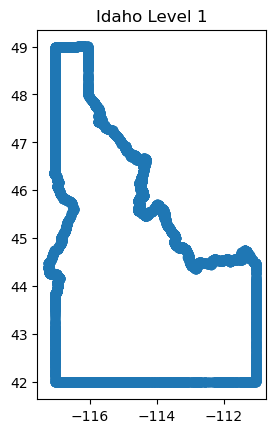

In [129]:
# Step3: Plot level 1
head_idaho_gdf.plot()
plt.title('Idaho Level 1')

In [130]:
mean_forward_length_l2 = head_idaho_gdf['len_forward'].mean()
mean_forward_length_l2

231.75125386819482

In [131]:
head_idaho_gdf_l2 = head_idaho_gdf[head_idaho_gdf['len_forward'] >= mean_forward_length_l2]
tail_idaho_gdf_l2 = head_idaho_gdf[head_idaho_gdf['len_forward'] < mean_forward_length_l2]

In [132]:
head = round((len(head_idaho_gdf_l2)/len(head_idaho_gdf))*100,2)
tail = round((len(tail_idaho_gdf_l2)/len(head_idaho_gdf))*100,2)
print(f'Level 2: Head = {head}%, Tail = {tail}%')

Level 2: Head = 24.37%, Tail = 75.63%


Text(0.5, 1.0, 'Idaho Level 2')

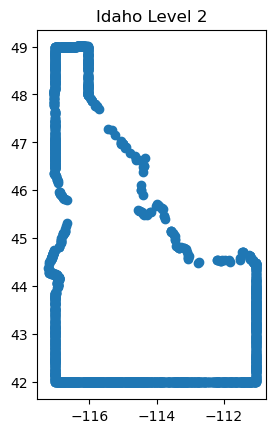

In [134]:
head_idaho_gdf_l2.plot()
plt.title('Idaho Level 2')

In [135]:
mean_forward_length_l3 = head_idaho_gdf_l2['len_forward'].mean()
mean_forward_length_l3

556.3632173095014

In [136]:
head_idaho_gdf_l3 = head_idaho_gdf_l2[head_idaho_gdf_l2['len_forward'] >= mean_forward_length_l3]
tail_idaho_gdf_l3 = head_idaho_gdf_l2[head_idaho_gdf_l2['len_forward'] < mean_forward_length_l3]

In [137]:
head = round((len(head_idaho_gdf_l3)/len(head_idaho_gdf_l2))*100,2)
tail = round((len(tail_idaho_gdf_l3)/len(head_idaho_gdf_l2))*100,2)
print(f'Level 2: Head = {head}%, Tail = {tail}%')

Level 2: Head = 31.09%, Tail = 68.91%


Text(0.5, 1.0, 'Idaho Level 3')

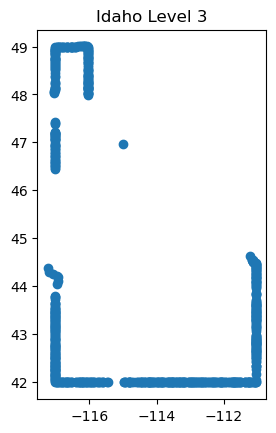

In [138]:
head_idaho_gdf_l3.plot()
plt.title('Idaho Level 3')

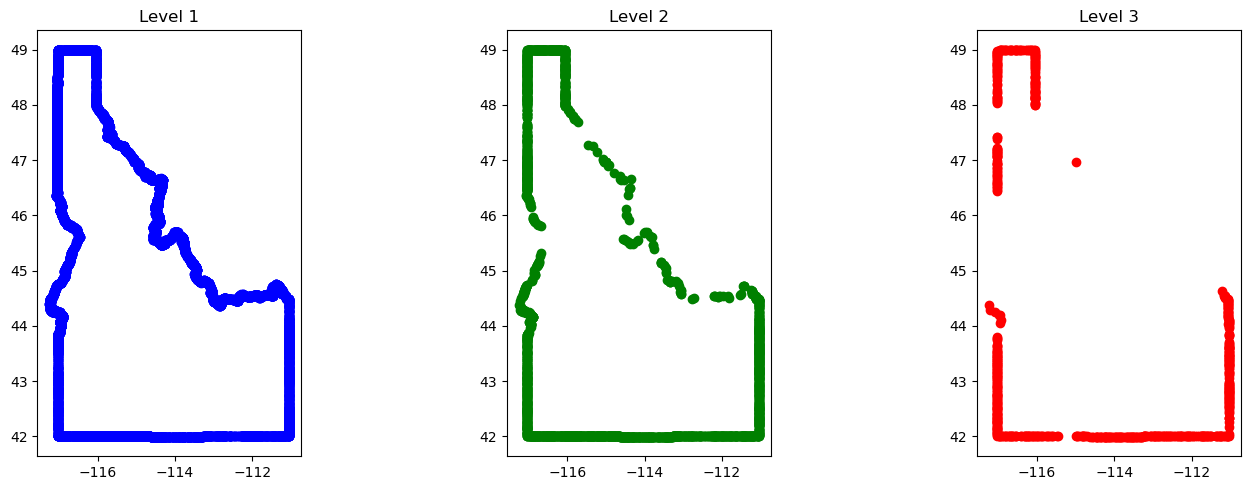

In [146]:
# Create subplots with three columns
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot each GeoDataFrame on a separate subplot
head_idaho_gdf.plot(ax=axs[0], color='blue')
axs[0].set_title('Level 1')

head_idaho_gdf_l2.plot(ax=axs[1], color='green')
axs[1].set_title('Level 2')

head_idaho_gdf_l3.plot(ax=axs[2], color='red')
axs[2].set_title('Level 3')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [148]:
head_idaho_gdf_l2.to_file(r'D:\Sid_Map_Projects\Georef_Mahi\Idaho_l2.shp')
head_idaho_gdf_l3.to_file(r'D:\Sid_Map_Projects\Georef_Mahi\Idaho_l3.shp')

C:\Users\Sidrcs\AppData\Local\Temp\ipykernel_13400\539143269.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  head_idaho_gdf_l2.to_file(r'D:\Sid_Map_Projects\Georef_Mahi\Idaho_l2.shp')
C:\Users\Sidrcs\AppData\Local\Temp\ipykernel_13400\539143269.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  head_idaho_gdf_l3.to_file(r'D:\Sid_Map_Projects\Georef_Mahi\Idaho_l3.shp')
